### Goals:

- Write a discrete time, stochastic simulation of individuals dispersing across a landscape over many generations so that they follow the porous medium equation, 
$$\frac{d}{dt} u(x,t) = \frac{\sigma^2}{2}\frac{d^2}{dx^2}(u(x,t)^2) + u(x, t)(1-u(x,t))$$
- Test if the distribution of simulated locations, $u(x, t)$, approximately satisfies the equation.

$u(x,t)$ is population per unit length

# A population analogue of the porous media equation

We'd like to do an analogue of
$$
    \partial_t n(t, x) = \partial_x^2 \left(n(t, x)^2\right) + n(t,x) (1 - n(t, x)) .
$$

If the death, birth, and establishment rates are $\mu$, $\gamma$, and $r$ respectively, then
$$
    \partial_t n(t, x) = r(x, t) \partial_x^2 \left(\gamma(x, t) n(t, x)\right) + n(t,x) \left(\gamma(x, t) - \mu(x, t)\right) ,
$$

First, we'll need to set $r(x, t) = 1$, and rescaling by carrying capacity so that $n(x, t) = N(x, t) / K$,
set $\gamma = n = N / K$.
Now, what about $\mu(x,t)$?
The above equation is actually obtained after speeding up time by $\theta$,
so we actually want to set dispersal distance to $1/\sqrt{\theta}$ and obtain
$$
    \theta \partial_t n(t, x) = \partial_x^2 \left(n(t, x)^2\right) + n(t,x) (1 - n(t, x)) .
$$
To do this, we want $\gamma - \mu = (1 - n) / \theta$, and so
$$
    \mu(x, t) = n(x, t) + \frac{n(x, t) - 1}{\theta} = \left(1 + \frac{1}{\theta}\right) n(x,t) - \frac{1}{\theta} .
$$
Note that $\mu \ge ((\theta + 1)/K - 1)/\theta$, so $\mu$ will always be $\ge 0$ if $\theta + 1 \ge K$.
However, we want to take $\theta/K \to 0$ to get a deterministic limit.

To check: at equilibrium, $\mu = \gamma$, which happens when $n=1$, i.e., $N = K$.

*However*, we're working in discrete time,
and death probabilities must be positive, so let's adjust this.

Each individual:

1. produces a single offspring with probability $1 - \exp(-dt \gamma)$, and then
2. dies with probability $1 - \exp(-dt \mu)$.

*Note:* at first we had offspring number equal to $dt \gamma$; but this produces unstable populations at large $N$,
so now "reproduction of a single offspring happens at rate $\gamma$, but only once per time step", like death.

*Note*: in SLiM, each life cycle does all births and then all deaths,
so that death rates are calculated while including the newly born individuals,
which might themselves die.

So, the average net contribution to the next generation per capita is
$$\begin{aligned}
    1 - e^{-dt \gamma}  + e^{-dt \mu}
    &=
        1 - \exp\left\{-dt N/K\right\}  + \exp\left\{-dt \left((1 + 1/\theta) N / K - 1/\theta\right)\right\} .
\end{aligned}$$
At $N=K$ this is stable, since this is equal to:
$$\begin{aligned}
    1 - e^{-dt}  + e^{-dt} = 1
\end{aligned}$$

Note that with this scheme $\mu < 0$ if
$$ N/K < 1/(1 + \theta) ,$$
so we should probably put some lower bound on $\mu$.

If we put a lower bound on the death rate -
perhaps at one-quarter of the death rate when $N=K$,
which is $\mu(1) = 1$ - then the population dies out below a certian point
(which might be OK).

Alternatively, we could put a lower bound on both - let both $\mu$ and $\gamma$ be constant
below $N = K/2$, i.e., below $n=1/2$.

Here are the birth, death, and net difference curves.

In [195]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

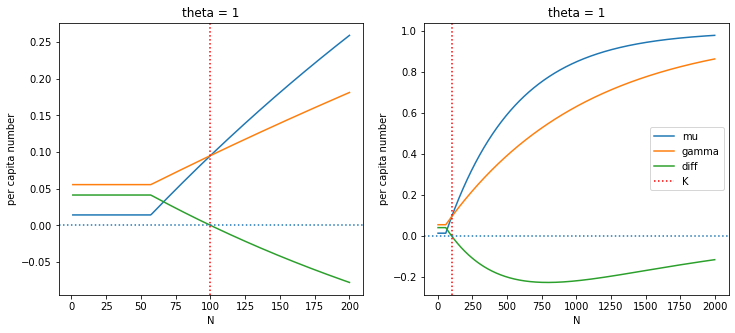

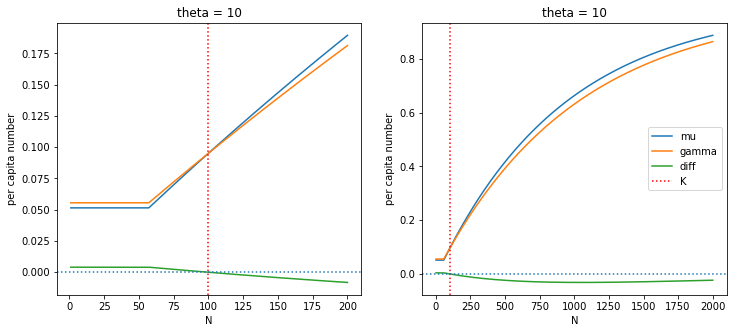

In [214]:
def gamma(N, K, theta, dt, min_n=0):
    return np.fmax(0, 1 - np.exp(- dt * np.fmax(min_n, N / K)))

def mu(N, K, theta, dt, min_n=0):
    return  1 - np.exp(- dt * ((1 + 1/theta) * np.fmax(min_n, N / K) - 1/theta))

for theta in [1, 10]:
    params = {
        "K" : 100,
        "theta" : theta,
        "min_n" : 4/7,
        "dt" : 0.1,
    }

    Nvals = [2 * params["K"], 20 * params["K"]]
    fig, axes = plt.subplots(1, len(Nvals), figsize=(12, 5))
    for max_N, ax in zip(Nvals, axes):
        N = 1 + np.arange(max_N)
        x = np.column_stack([
            mu(N, **params),
            gamma(N, **params),
            gamma(N, **params) - mu(N, **params),
        ])
        ax.plot(N, x, label=["mu", "gamma", "diff"])
        ax.set_xlabel("N")
        ax.set_ylabel("per capita number")
        ax.axvline(params["K"], c="r", ls=":", label="K")
        ax.axhline(0, ls=":")
        ax.set_title(f"theta = {params['theta']}")

    ax.legend();

## Nonspatial check

Here's a nonspatial simulation to check that dynamics are stable.

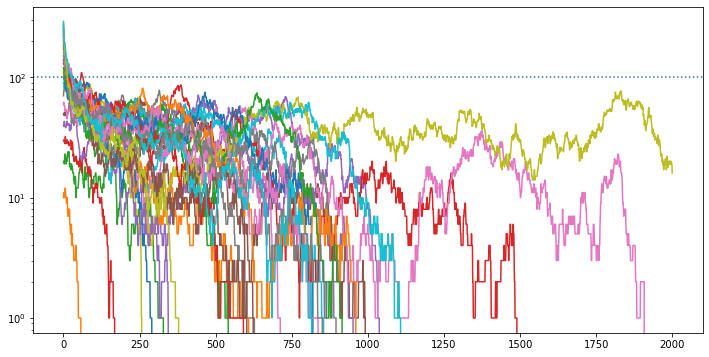

In [215]:
rng = np.random.default_rng(123)

params = {
    "K" : 100,
    "theta" : 20,
    "min_n" : 4/7,
    "dt" : 0.1,
}

def next_gen(N, **kwargs):
    offspring = rng.binomial(n=N, p=gamma(N, **kwargs), size=len(N))
    survivors = rng.binomial(n=N + offspring, p=1 - mu(N + offspring, **kwargs), size=len(N))
    return survivors

Nmat = np.full((2000, 30), -1, dtype='int')
Nmat[0,:] = 10 * np.arange(Nmat.shape[1])
for k in range(1, Nmat.shape[0]):
    Nmat[k, :] = next_gen(Nmat[k-1, :], **params)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(Nmat)
ax.axhline(params["K"], ls=":")
ax.set_yscale("log");

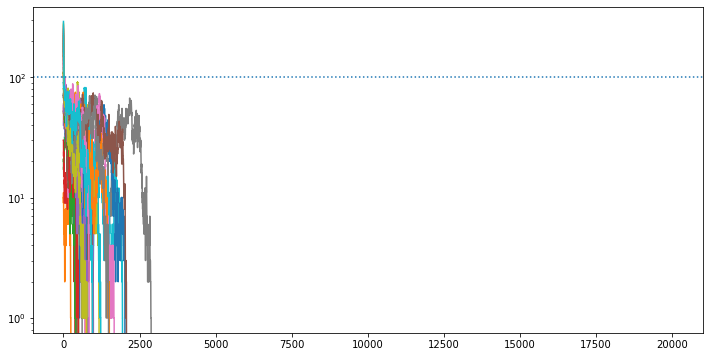

In [216]:
Nmat = np.full((20000, 30), -1, dtype='int')
Nmat[0,:] = 10 * np.arange(Nmat.shape[1])
for k in range(1, Nmat.shape[0]):
    Nmat[k, :] = next_gen(Nmat[k-1, :], **params)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(Nmat)
ax.axhline(params["K"], ls=":")
ax.set_yscale("log");

## Discrete-time adjustments

Note that this population is *not* stable.
The reason is the time discretization: births happen first,
which increase the population size at which death rates are calculated,
and then new offspring are subject to death as well.
(This is as SLiM does things, by default.)

To fix this, consider what's actually going on:
given a current size of $N$,
the number of births, $B$, are Binomial$(N, 1-\exp(-dt \lambda))$
(for some $\lambda$ which depends on $N$),
and then given $B$, the number of survivors are Binomial$(N+B, \exp(-dt \mu((N+B)/K)))$.
For this to be stable, we want the mean of this to equal $N$, i.e., that
$$\begin{aligned}
  N = \mathbb{E}\left[(N+B)e^{-dt \mu((N+B)/K)}\right] 
\end{aligned}$$
when $N = K$.

To do this, we will replace $\mu$ by $\mu - \delta$ -
i.e., increasing survival probability by $e^{\delta dt}$.
We then want
$$
  K = e^{\delta dt} \mathbb{E}_{N=K}\left[(N+B)e^{-dt \mu((N+B)/K)}\right] ,
$$
i.e.,
$$
  \delta = \frac{1}{dt} \left( 
  \log(K) - \log \mathbb{E}_{N=K}\left[(N+B)e^{-dt \mu((N+B)/K)}\right]
  \right) .
$$

Now consider the case at hand, where $\mu(n) = a n - b$,
where $a = 1 + 1/\theta$ and $b = - 1/\theta$.
(We will be adding $\delta$ to $b$.)
To compute $\delta$, first note that
$$\begin{aligned}
\phi(\alpha) &:= \mathbb{E}\left[\exp(-\alpha(N+B))\right] \\
     &= e^{-\alpha N} \left( dt \lambda e^{-\alpha} + (1 - dt \lambda) \right)^N ,
\end{aligned}$$
and so 
$$\begin{aligned}
\mathbb{E}\left[(N+B)\exp(-dt \mu((N+B)/K))\right] 
    &= e^{-dt b} \left(- \frac{d}{d\alpha} \right) \phi(a dt/K) \\
    &= N e^{-dt(aN/K + b)}
    \left\{ 1 + \lambda dt (2 e^{-adt/K} - 1) \right\}
    \left(1 - \lambda dt (1 - e^{-a dt/K}) \right)^{N-1} .
\end{aligned}$$
Plugging this in to the equation for $\delta$,
with $\lambda=1$ since $N=K$, we get
$$\begin{aligned}
  \delta 
  = 
  a + b
  -
  \frac{1}{dt} \left( 
    \log(1 + dt (2 e^{-a dt/K} - 1))
    + (K-1) \log(1 - dt (1 - e^{-a dt / K}))
  \right) .
\end{aligned}$$

In [244]:
def check_math():
    alpha = 0.01
    N = 100
    lam = 0.2
    a = 0.3
    b = 0.7
    dt = 0.01
    K = 120
    B = rng.binomial(n=N, p=dt*lam, size=100000)
    print (
        np.mean((N + B) * np.exp(-dt * (a * (N + B)/K + b))),
        (
            N * np.exp(-dt * (a * N /K + b)) 
                * (1 + lam * dt * (2 * np.exp(-a * dt / K) - 1)) 
                * (1 - lam * dt * (1 - np.exp(-a * dt / K))) ** (N-1)
        )
    )

check_math()

99.25393388801935 99.25210604244097


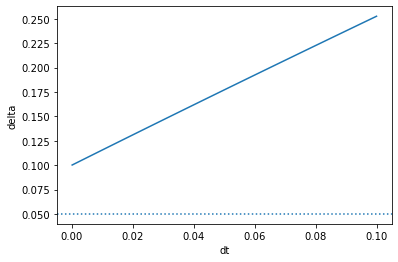

In [246]:
def get_delta(K, dt, theta, **kwargs):
    a = 1 + 1/theta
    b = 1/theta
    delta = a + b - (1/dt) * (
        np.log(1 + dt * (2 * np.exp(-a * dt / K) - 1))
        + 
        (K - 1) * np.log(1 - dt * (1 - np.exp(-a * dt / K)))
    )
    return delta

params = {
    "K" : 100,
    "theta" : 20,
    "min_n" : 4/7,
    "dt" : 0.1,
}

dt_vals = np.linspace(0.0001, 0.1, 51)
b_vals = np.array([get_delta(K=params["K"], theta=params["theta"], dt=dt) for dt in dt_vals])
fig, ax = plt.subplots()
ax.plot(dt_vals, b_vals)
ax.set_xlabel("dt")
ax.set_ylabel("delta")
ax.axhline(1/params["theta"], ls=":");

In [ ]:
def revised_mu(N, K, theta, dt, min_n=0):
    
    return  1 - np.exp(- dt * ((1 + 1/theta) * np.fmax(min_n, N / K) - 1/theta))

rng = np.random.default_rng(123)

params = {
    "K" : 100,
    "theta" : 20,
    "min_n" : 4/7,
    "dt" : 0.1,
}

def revised_next_gen(N, **kwargs):
    offspring = rng.binomial(n=N, p=gamma(N, **kwargs), size=len(N))
    survivors = rng.binomial(n=N + offspring, p=1 - mu(N + offspring, **kwargs), size=len(N))
    return survivors

Nmat = np.full((2000, 30), -1, dtype='int')
Nmat[0,:] = 10 * np.arange(Nmat.shape[1])
for k in range(1, Nmat.shape[0]):
    Nmat[k, :] = revised_next_gen(Nmat[k-1, :], **params)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(Nmat)
ax.axhline(params["K"], ls=":")
ax.set_yscale("log");

### Test if the locations follow the PME

1. Estimate $u(x, t)$ from the simulated locations
2. Calculate discrete approximations of $\frac{d}{dt} \widehat{u(x,t)}$ and  $\frac{d^2}{dx^2} \left(\widehat{u(x,t)}^2 \right)$

### Reasons simulated locations might not follow the PME

1. Edge effects
2. Discretization of time
3. Discretization of space in computing derivatives
4. Using differential equation instead of integral
5. Too much demographic noise
6. Coding error

In [6]:
import msprime, pyslim
import tskit
import json
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats

In [14]:
%%bash
mkdir -p pme_check
echo '{
    "THETA" : 10,
    "K" : 100,
    "MIN_DENSITY" : 0.55,
    "DT" : 0.1,
    "EPSILON" : 0.2,
    "DISPERSAL_SIGMA" : 1.0,
    "WIDTH" : 20,
    "HEIGHT" : 1.3,
    "RUNTIME" : 100,
    "DEBUG" : false
}' > pme_check/params.json
slim -d 'OUTDIR="pme_check"' -s 1234 pme.slim &> pme_check/py.log

// Initial random seed:
1234

// RunInitializeCallbacks():
initializeSLiMModelType(modelType = 'nonWF');
initializeSLiMOptions(dimensionality = 'xy');
initializeTreeSeq(retainCoalescentOnly = F);
initializeMutationRate(0);
initializeMutationType(1, 0.5, "f", 0);
initializeGenomicElementType(1, m1, 1);
initializeGenomicElement(g1, 0, 99999999);
initializeRecombinationRate(1e-08);
-------------

  DEBUG: F
  DISPERSAL_SIGMA: 1.0
  DT: 0.1
  HEIGHT: 1.3
  IMAGEPATH: pme_check/pme_1234_
  K: 100
  LOGPATH: pme_check/pme_1234.log
  MIN_DENSITY: 0.55
  OUTDIR: pme_check
  OUTPATH: pme_check/pme_1234.trees
  RUNTIME: 100
  SIGMA: 0.2
  THETA: 10
  WIDTH: 20
  read_from_paramfile: pme_check/params.json
-------------

theta / pop. density  = 0.1 (deterministic is -> 0)
(dispersal) neighborhood size = 400.0 (d=1) 1256.64(d=2)
interaction neighborhood = 80.0 (d=1) 50.2655(d=2)
dispersal / interaction =  5.0 (< 1 is patchy)
initializeInteractionType(1, "xy", reciprocal=T, maxDistance=0.6);

// Sta

In [7]:
# Results
ts = pyslim.load("pme_check/pme_1234.trees")
params = ts.metadata['SLiM']['user_metadata']

Find the values of $\sigma$, $dt$, and $K$ used in the simulation.

In [8]:
sigma = ts.metadata['SLiM']['user_metadata']['DISPERSAL_SIGMA'][0]
dt = ts.metadata['SLiM']['user_metadata']['DT'][0]
K = ts.metadata['SLiM']['user_metadata']['K'][0]

## Numerical solutions to the PDE

We'll look at a discretization where:

$h$ - size of $x$ bins

$\widehat{u_t(x)} = \frac{\text{population size between } x \text{ and } x + h \text{ at time } t}{hK}$

In [9]:
h = 0.8
T = max(ts.individual_times)
y_bins = [0, params['HEIGHT'][0]]
y_mids = y_bins[1:] - np.diff(y_bins)/2
x_bins = np.arange(0, params['WIDTH'][0] + h, h)
x_mids = x_bins[1:] - np.diff(x_bins)/2
t_bins = np.arange(0, T + 1)

# Population sizes for each time step within each x bin
popsize = pyslim.population_size(ts, x_bins, y_bins, t_bins)

In [10]:
# "Observed" values of u
uhat = np.sum(popsize, axis=1)/(K*h)
assert uhat.shape[0] == len(x_bins) - 1
assert uhat.shape[1] == len(t_bins) - 1

## Plot of $\hat{u}$

You can see that the population starts on the left and moves to the right. In the initial generation, the population density is about 1 from 0 to 5 and drops to zero at 5, and over the rest of the generations the point where $\hat{u}$ drops to zero moves to the right.

### Starting and ending state

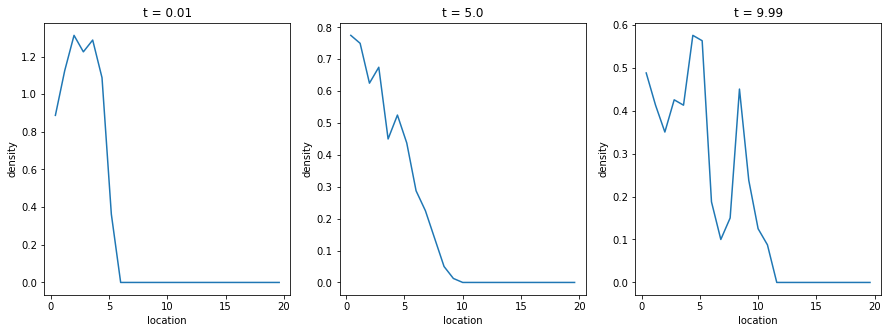

In [107]:
jvals = [int(T-1), int(T/2), 0]
fig, axes = plt.subplots(1, len(jvals), figsize=(15,5))
for j, ax in zip(jvals, axes):
    ax.plot(x_mids, uhat[:,j])
    ax.set_title(f"t = {(T - j)*dt}")
    ax.set_xlabel("location")
    ax.set_ylabel("density");

### For more generations

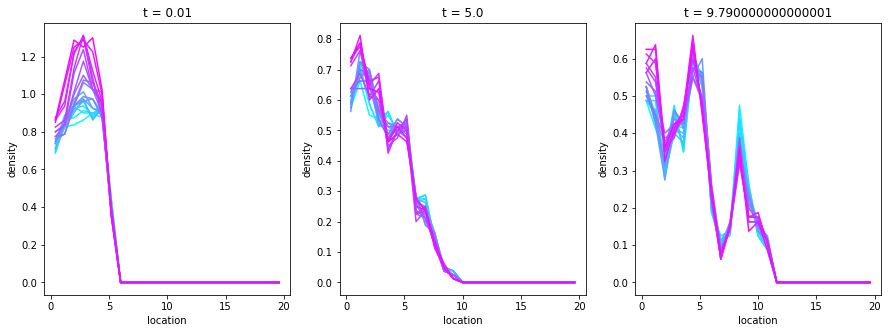

In [108]:
cm = matplotlib.cm.cool

nsteps = 20
jvals = [int(T-1), int(T/2), nsteps]
fig, axes = plt.subplots(1, len(jvals), figsize=(15,5))
for k, ax in zip(jvals, axes):
    jsteps = np.arange(k-nsteps, k)
    for m, j in enumerate(jsteps):
        ax.plot(x_mids, uhat[:,j], c=cm(m/nsteps))
    ax.set_title(f"t = {(T - k)*dt}")
    ax.set_xlabel("location")
    ax.set_ylabel("density");

## Compare to the analytical solution

First we need to get the initial value.
For this we'll integrate each basis function against the locations
of everyone alive at the oldest (initial) time.

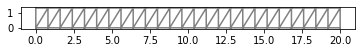

In [145]:
import fenics

mesh = fenics.RectangleMesh(
    p0=fenics.Point(0, 0),
    p1=fenics.Point(params['WIDTH'][0], params['HEIGHT'][0]),
    nx=len(x_bins) - 1,
    ny=len(y_bins) - 1,
)
V = fenics.FunctionSpace(mesh, 'P', 1)

fenics.plot(init_mesh);

In [146]:
def basis_functions(V):
    u0 = fenics.Function(V)
    u0_vals = u0.vector()
    for j in range(V.dim()):
        a = np.zeros(V.dim())
        a[j] = 1
        u0_vals[:] = a
        yield u0

alive_xy = np.array([ts.individual(i).location[:2] for i in ts.individuals_alive_at(T)])
init_vals = np.zeros(V.dim())
for j, u0 in enumerate(basis_functions(V)):
    for xy in alive_xy:
        init_vals[j] += u0(*xy) / (K * h)

u0.vector()[:] = init_vals

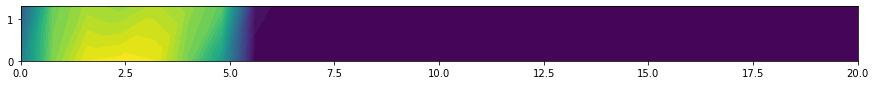

In [147]:
fig, ax = plt.subplots(figsize=(15, 5))
fenics.plot(u0);

In [148]:
fenics_params = {
    "dt" : 0.05,    # preferred time step
    "nx" : 101,           # mesh width
    "ny" : 2,             # mesh height
}
    
# Create mesh and define function space
nx, ny = 101, 2
mesh = fenics.RectangleMesh(
    p0=fenics.Point(0, 0),
    p1=fenics.Point(params['WIDTH'][0], params['HEIGHT'][0]),
    nx=fenics_params['nx'],
    ny=fenics_params['ny'],
)
V = fenics.FunctionSpace(mesh, 'P', 1)

# use this to map values back to space
ij = V.tabulate_dof_coordinates()
ut = (ij[:,1] == 0.0)

# Define initial value
# u_n = fenics.Expression(f"x[0] < {np.max(mesh.coordinates()[:,0]) / 4} ? 1 : 0;", element=V.ufl_element())
u_n = fenics.interpolate(u0, V)

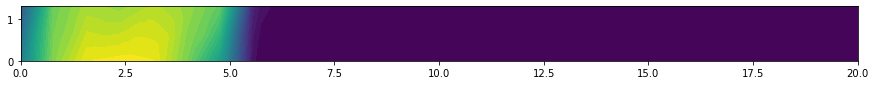

In [149]:
fig, ax = plt.subplots(figsize=(15, 5))
fenics.plot(u_n);

In [150]:
# Define variational problem
u = fenics.Function(V)
v = fenics.TestFunction(V)
def get_F(u, v, dt, sigma=params["DISPERSAL_SIGMA"][0]):
    dx = fenics.dx
    F = (u * v * dx
         + dt * (sigma**2 / 2)
            * fenics.dot(fenics.grad(u**2), fenics.grad(v)) * dx
         - dt * u * (1 - u) * v * dx
         - u_n * v * dx
    )
    return F

def observed(u, x):
    y0 = np.mean(mesh.coordinates()[:,1])
    return np.array([
        u(x0, y0) for x0 in x
    ])

fenics.set_log_active(False)

output_times = t_bins * dt # <-- this is SLiM's dt
output = np.empty((len(x_mids), len(output_times)))
output[:, 0] = observed(u_n, x_mids)
# Time-stepping
for j in range(len(output_times) - 1):
    t_diff = output_times[j + 1] - output_times[j]
    num_dt = int(np.ceil(t_diff / fenics_params['dt']))
    dt = t_diff / num_dt
    F = get_F(u, v, dt=dt)
    for _ in range(num_dt):
        # Compute solution
        fenics.solve(F == 0, u)
        # Update previous solution
        u_n.assign(u)
    output[:, j + 1] = observed(u, x_mids)

In [151]:
np.min(output), np.max(output)

(-0.00785317786325447, 0.9996938749475641)

Now, let's plot this!

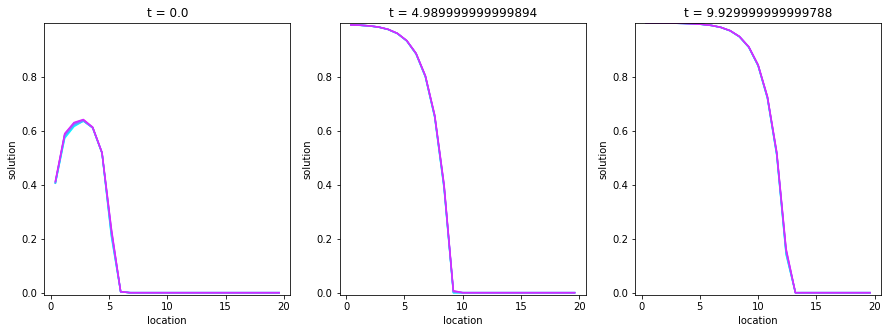

In [152]:
cm = matplotlib.cm.cool

nsteps = 6
jvals = [0, int(len(output_times)/2), len(output_times) - nsteps]
fig, axes = plt.subplots(1, len(jvals), figsize=(15,5))
for k, ax in zip(jvals, axes):
    jsteps = np.arange(k, k + nsteps)
    for m, j in enumerate(jsteps):
        ax.plot(x_mids, output[:,j], c=cm(m/nsteps))
    ax.set_ylim(np.min(output), np.max(output))
    ax.set_title(f"t = {output_times[k]}")
    ax.set_xlabel("location")
    ax.set_ylabel("solution");

Is evaluating at midpoints giving us the right thing?

In [179]:
def integrate_bins(u, x_bins):
    for k in range(len(x_bins) - 1):
        out = np.empty(len(x_bins) - 1)
        uu = fenics.Expression(
            f"(x[0] >= {x_bins[k]} "
            f"&& x[0] < {x_bins[k+1]})"
            f"? 1 / {x_bins[k+1] - x_bins[k]} : 0;",
            element=V.ufl_element()
        )
        out[k] = fenics.assemble(uu * u * fenics.dx)
    return out

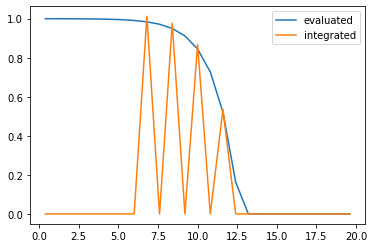

In [180]:
obs_u = observed(u, x_mids)
int_u = integrate_bins(u, x_bins)
fig, ax = plt.subplots()
ax.plot(x_mids, obs_u, label='evaluated')
ax.plot(x_mids, int_u, label='integrated')
ax.legend();

## Compare the two!

Next, we'll compare the simulation to the numerical solutions!

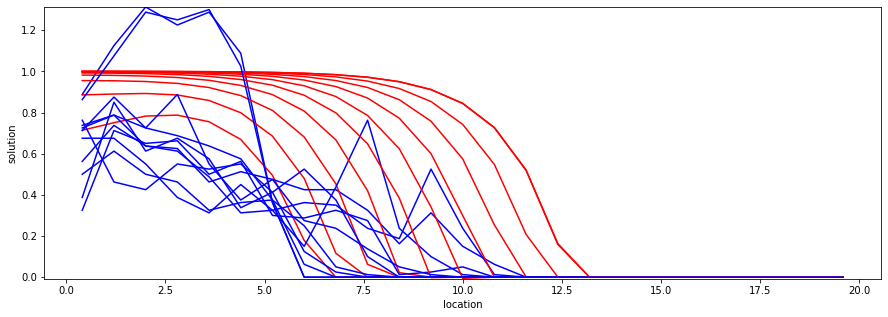

In [170]:
plot_t = output_times[np.linspace(0, T-1, 11).astype("int")]
fig, ax = plt.subplots(1, figsize=(15,5))

for t in plot_t:
    j = (output_times.searchsorted(t) - 1)
    ax.plot(x_mids, output[:,j], c='red')
    ax.plot(x_mids, uhat[:,j], c='blue')

ax.set_ylim(min(np.min(uhat), np.min(output)),
            max(np.max(uhat), np.max(output)))
ax.set_xlabel("location")
ax.set_ylabel("solution");


## Estimating $u$ and calculating discrete derivatives

$\frac{d}{dt} \widehat{u_t(x)} \approx (\widehat{u(x, t)} - \widehat{u(x, t - dt)})/dt$

$\frac{d^2}{dx^2} \widehat{u(x,t)^2} \approx \frac{\widehat{\frac{d}{dx}u(x + h/2, t)^2} - \widehat{\frac{d}{dx}u(x- h/2, t)^2}}{h} = \frac{\frac{\widehat{u(x + h, t)^2} - \widehat{u(x, t)^2}}{h} - \frac{\widehat{u(x, t)^2} - \widehat{u(x - h, t)^2}}{h}}{h} = \frac{\widehat{u(x + h, t)^2} - 2\widehat{u(x, t)^2} + \widehat{u(x - h, t)^2}}{h^2}$

`uhat` is a $n_x$ = `len(x_bins) - 1` by $n_t$ = `len(t_bins) - 1` grid.

$d/dt$ `uhat` between `x_bins[i]` and `x_bins[i + 1]` and  `t_bins[j]` and `t_bins[j + 1]` $\approx$ `uhat[i, j -1] - uhat[i, j]`

So I can calculate $d/dt$ for $i = 0, 1, ..., n_x -1$ and $j = 1, 2, ..., n_t - 1$

$d^2/dx^2$ `uhat**2` between `x_bins[i]` and `x_bins[i + 1]` and  `t_bins[j]` and `t_bins[j + 1]` $\approx$ `(uhat[i + 1, j]**2 - 2*uhat[i, j]**2 + uhat[i - 1, j]**2)/h**2`

So I can calculate $d^2/dx^2$ for $i = 1, ..., n_x - 2$ and $j = 0, 1, 2, ..., n_t - 1$

And both for $i = 1, ..., n_x - 2$ and $j = 1, 2, ..., n_t - 1$

In [24]:
# Compute left and right hand sides of the PME for each x and each time step using discrete derivatives
# Store each in an array, first axis is x, second axis is time

nx = np.shape(uhat)[0]
nt = np.shape(uhat)[1]

i_vals = np.arange(1, nx - 1)
j_vals = np.arange(1, nt)

x_vals = np.empty([len(i_vals),len(j_vals)])
t_vals = np.empty([len(i_vals),len(j_vals)])

lhs = np.empty([len(i_vals),len(j_vals)])
rhs = np.empty([len(i_vals),len(j_vals)])

for i_index, i in enumerate(i_vals):
    for j_index, j in enumerate(j_vals):
        x = x_bins[i]
        t = t_bins[j]
        
        uhatt = uhat[i, j]
        uhattm1  = uhat[i, j-1]
        
        ddt = (uhattm1 - uhatt)
    
        d2dx2 = (uhat[i + 1, j]**2 - 2*uhat[i, j]**2 + uhat[i - 1, j]**2)/h**2
    
        x_vals[i_index, j_index] = x
        t_vals[i_index, j_index] = t   
    
        lhs[i_index, j_index] = ddt
        #rhs[index] = dt*((sigma**2/2)*d2dx2 + uhatt*(1 - uhatt))
        # birth minus death instead
        rhs[i_index, j_index] = (
            dt * (sigma**2/2) * d2dx2
            + uhatt * (
                gamma(uhatt * K, K, params['THETA'][0], params['MIN_DENSITY'][0])
                - mu(uhatt * K, K, params['THETA'][0], params['MIN_DENSITY'][0])
            )
        )

### LHS of PME vs RHS

We want a cloud of points around the $y=x$ line.

In [30]:
# Sum over all locations

# Without edges
#sum_lhs = np.sum(lhs[3:-3,:-50], axis = 0)
#sum_rhs = np.sum(rhs[3:-3,:-50], axis = 0)

sum_lhs = np.sum(lhs, axis = 0)
sum_rhs = np.sum(rhs, axis = 0)

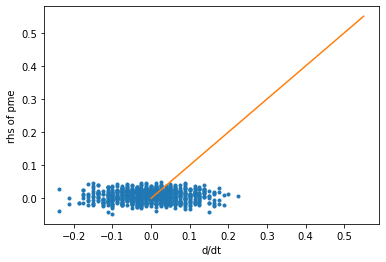

In [31]:
fig, ax = plt.subplots()
ax.plot(sum_lhs, sum_rhs, '.')
ax.plot([0, 0.55], [0, 0.55])
ax.set_xlabel("d/dt")
ax.set_ylabel("rhs of pme")
plt.show()